In [1]:
# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================


"""<br />
© 2020 Total S.A., All Rights Reserved.<br />
"""<br />
Limits Metrics computation<br />
03/16/2020

In [2]:
# Uninstall old packages
!pip3 uninstall -r requirements_uninstall.txt -y


Found existing installation: tensorflow 2.1.0
Uninstalling tensorflow-2.1.0:
  Successfully uninstalled tensorflow-2.1.0
Found existing installation: numpy 1.18.0
Uninstalling numpy-1.18.0:
  Successfully uninstalled numpy-1.18.0
Found existing installation: pandas 0.25.3
Uninstalling pandas-0.25.3:
  Successfully uninstalled pandas-0.25.3
Found existing installation: scipy 1.4.1
Uninstalling scipy-1.4.1:
  Successfully uninstalled scipy-1.4.1
Found existing installation: scikit-learn 0.22
Uninstalling scikit-learn-0.22:
  Successfully uninstalled scikit-learn-0.22
Found existing installation: google-api-python-client 1.7.11
Uninstalling google-api-python-client-1.7.11:
  Successfully uninstalled google-api-python-client-1.7.11
Found existing installation: gcsfs 0.6.1
Uninstalling gcsfs-0.6.1:
  Successfully uninstalled gcsfs-0.6.1
Found existing installation: google-cloud 0.34.0
Uninstalling google-cloud-0.34.0:
  Successfully uninstalled google-cloud-0.34.0
Found existing installatio

In [3]:
# Install packages
# https://cloud.google.com/ai-platform/training/docs/runtime-version-list
!pip3 install -r requirements-rt2.1.txt --user --no-cache-dir --use-feature=2020-resolver


     |██████████████████████▉         | 300.4 MB 139.0 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 421.8 MB 92.3 MB/s eta 0:00:011
     |████████████████████████████████| 20.1 MB 49.5 MB/s eta 0:00:01
     |████████████████████████████████| 10.4 MB 50.3 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 62.1 MB/s eta 0:00:01
     |████████████████████████████████| 7.0 MB 64.0 MB/s eta 0:00:01
     |████████████████████████████████| 142 kB 89.1 MB/s eta 0:00:01
     |████████████████████████████████| 72 kB 38.1 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 60.8 MB/s eta 0:00:01
  Created wheel for google-api-python-client: filename=google_api_python_client-1.7.11-py3-none-any.whl size=56530 sha256=92fa27a0f0e5cacf49021f12171c90c7bfbf7175d4d96784f392a40c88c9b162
  Stored in directory: /tmp/pip-ephem-wheel-cache-spwqaehs/wheels/b6/04/f6/ae7211f4531abd8ac91e3fae5d19a4d8b52803362548ea9f66
  Created wheel for cloudml-hypertune: filename=cloudml_hypertune-0.1.0.dev6-py2.py3-none-any.whl size=3987 sha256=2bc1187b9a64da

In [21]:
# Import packages
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

import numpy as np
from google.cloud import storage
import tensorflow as tf
#import matplotlib.pyplot as plt
#from tensorflow.keras import models

print("TF Version= ", tf.__version__)
print("Keras Version= ", tf.keras.__version__)


TF Version=  2.1.0
Keras Version=  2.2.4-tf


In [22]:
# Utility functions

#------
def find_best_model_dir(model_dir, offset=1, maxFlag=1):
    # Get a list of model directories
    all_models = ! gsutil ls $model_dir
    print("")
    print("All Models = ")
    print(*all_models, sep='\n')

    # Check if model dirs exist
    if (("CommandException" in all_models[0]) or (len(all_models) <= 1)):
        print("Create the models first.")
        return ""

    # Find the best model from checkpoints
    import re
    best_acc = -np.Inf
    if (maxFlag != 1):
        best_acc = np.Inf
    best_model_dir = ""
    tup_list = []
    for i in range(1,len(all_models)):
        all_floats = re.findall(r"[-+]?\d*\.\d+|\d+", all_models[i]) #Find the floats in the string
        cur_acc = -float(all_floats[-offset]) #which item is the model optimization metric
        tup_list.append([all_models[i],cur_acc])
        if (maxFlag*(cur_acc > best_acc) or (1-maxFlag)*(cur_acc < best_acc)):
            best_acc = cur_acc
            best_model_dir = all_models[i]
    if maxFlag:
        tup_list.sort(key=lambda tup: tup[1], reverse=False)
    else:
        tup_list.sort(key=lambda tup: tup[1], reverse=True)
    for i in range(len(tup_list)):
        print(tup_list[i][0])
    print("Best Accuracy  from Checkpoints = ", best_acc)
    print("Best Model Dir from Checkpoints = ", best_model_dir)
    
    return best_model_dir


In [23]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors
import json

#------
# Python module to get the best hypertuned model parameters
def pyth_get_hypertuned_parameters(project_name, job_name, maxFlag):
    # Define the credentials for the service account
    #credentials = service_account.Credentials.from_service_account_file(<PATH TO CREDENTIALS JSON>)
    credentials = GoogleCredentials.get_application_default()

    # Define the project id and the job id and format it for the api request
    project_id = 'projects/{}'.format(project_name)
    job_id = '{}/jobs/{}'.format(project_id, job_name)

    # Build the service
    cloudml = discovery.build('ml', 'v1', cache_discovery=False, credentials=credentials)

    # Execute the request and pass in the job id
    request = cloudml.projects().jobs().get(name=job_id)

    try:
        response = request.execute()
        # Handle a successful request
    except errors.HttpError as err:
        tf.compat.v1.logging.error('There was an error getting the hyperparameters. Check the details:')
        tf.compat.v1.logging.error(err._get_reason())

    # Get just the best hp values
    if maxFlag:
        best_model = response['trainingOutput']['trials'][0]
    else:
        best_model = response['trainingOutput']['trials'][-1]
    #print('Best Hyperparameters:')
    #print(json.dumps(best_model, indent=4))

    nTrials = len(response['trainingOutput']['trials'])
    for i in range(0,nTrials):
        state = response['trainingOutput']['trials'][i]['state']
        trialId = response['trainingOutput']['trials'][i]['trialId']
        objV = -1
        if (state == 'SUCCEEDED'):
            objV = response['trainingOutput']['trials'][i]['finalMetric']['objectiveValue']
        print('objective=', objV, ' trialId=', trialId, state)
        d = response['trainingOutput']['trials'][i]['hyperparameters']
        for key, value in d.items():
            print('    ', key, value)
    return best_model


In [24]:
# Plot original image overlaid by the fault labels
# image_array is np.array(num_images, x_size, y_size)
# label_array is np.array(num_images, x_size, y_size)

import matplotlib.pyplot as plt

def plot_images(image_array, label_array):
    fig, axarr = plt.subplots(4,4, figsize=(16, 16))
    for i in range(4):
        for j in range(4):
            axarr[i,j].set_title('Image-'+str(4*i+j))
            axarr[i,j].imshow(image_array[4*i+j,:,:], cmap='gray')
            axarr[i,j].imshow(label_array[4*i+j,:,:], alpha=0.3)


# Setup

In [25]:
USER = 'cchatterj'
PROJECT_ID = 'codev-257422' #$(gcloud config list project --format "value(core.project)")
BUCKET_NAME = 'chanchal-sandbox'
FOLDER_NAME = 'ht-tf-data'
REGION = 'us-central1'
RUNTIME_VERSION = 2.1
JOB_DIR   = 'gs://' + BUCKET_NAME + '/' + FOLDER_NAME + '/jobdir'
MODEL_DIR = 'gs://' + BUCKET_NAME + '/' + FOLDER_NAME + '/models'


In [26]:
!gcloud config list
#!gcloud config config-helper --format "value(configuration.properties.core.project)"


[core]
account = 914965210145-compute@developer.gserviceaccount.com
disable_usage_reporting = True
project = codev-257422

Your active configuration is: [default]


In [8]:
# Clean old job logs, job packages and models
!gsutil -m -q rm $JOB_DIR/packages/**
!gsutil -m -q rm $MODEL_DIR/model**


In [9]:
# Copy images and labels from GCS to local storage
'''
data_dir = 'gs://codev-test-data/FAULT_TRAINING_SET/SYNTHETIC_OPTIM/seismic'
for i in range(100):
    s = 'image_inline_i%04d.png' % i
    !gsutil -m cp $data_dir/$s ./data_dir
label_dir = 'gs://codev-test-data/FAULT_TRAINING_SET/SYNTHETIC_OPTIM/label'
for i in range(100):
    s = 'image_inline_i%04d.png' % i
    !gsutil -m cp $label_dir/$s ./label_dir
'''


"\ndata_dir = 'gs://codev-test-data/FAULT_TRAINING_SET/SYNTHETIC_OPTIM/seismic'\nfor i in range(100):\n    s = 'image_inline_i%04d.png' % i\n    !gsutil -m cp $data_dir/$s ./data_dir\nlabel_dir = 'gs://codev-test-data/FAULT_TRAINING_SET/SYNTHETIC_OPTIM/label'\nfor i in range(100):\n    s = 'image_inline_i%04d.png' % i\n    !gsutil -m cp $label_dir/$s ./label_dir\n"

# UNET-FPN32-sl1 Model

In [27]:
# Create the tf_trainer directory and load the trainer files in it
!mkdir -p trainer


In [28]:
%%writefile ./trainer/inputs.py

# Create the train and label lists
import math
import numpy as np
#import imageio
#from google.cloud import storage
import io
import tensorflow as tf
from PIL import Image

#------
def readImage(image_path):
    img = tf.io.gfile.GFile(image_path, 'rb').read()
    img = io.BytesIO(img)
    img = np.array(Image.open(img).convert('L')).astype(dtype='int32')
    height, width = img.shape
    # clipping 
    h = int(height/16)*16
    w = int(width/16)*16
    image = img[:h, :w]
    return image

#------
def load_data(data_file_path: str, label_file_path: str, rangeIndices, batch_size) -> tf.data.Dataset:
    seismic = []
    for i in rangeIndices:
        im = readImage(data_file_path+'/image_inline_i%04d.png' % i)
        im = np.array(im).astype(dtype='float32')/255
        (h,w) = im.shape
        im = np.reshape(im, (h,w,1))
        seismic.append(im)

    label = []
    for i in rangeIndices:
        im = readImage(label_file_path+'/image_inline_i%04d.png' % i)
        im = np.array(im).astype(dtype='float32')
        (h,w) = im.shape
        im = np.reshape(im, (h,w,1))
        label.append(im)

    #for items in seismic:
    #    print(items)

    seismic = np.array(seismic)
    label = np.array(label)
    print("Data  Shape = ", seismic.shape)
    print("Label Shape = ", label.shape)
    
    #return seismic, label
    
    dataset = tf.data.Dataset.from_tensor_slices((seismic, label))
    dataset = dataset.shuffle(100).batch(batch_size)
    
    return dataset



Overwriting ./trainer/inputs.py


In [29]:
%%writefile ./trainer/model.py

# UNET-FPN32-sl1.py

import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import Input, layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.activations import softmax

def create_convolution_block(input_layer,
                             n_filters,
                             batch_normalization=True,
                             kernel=(3, 3),
                             activation=layers.ReLU,
                             padding='same',
                             strides=(1, 1),
                             trainable = True):
    """Creates the convolution block."""
    layer = layers.Conv2D(
      n_filters, kernel, padding=padding, strides=strides, trainable = trainable)(
          input_layer)
    if batch_normalization:
        layer = layers.BatchNormalization(momentum=0.9)(layer)
    if activation is None:
        return layers.Activation('relu')(layer)
    else:
        return activation()(layer)

def create_localization_module(input_layer, n_filters):
    convolution1 = create_convolution_block(input_layer, n_filters)
    convolution2 = create_convolution_block(
      convolution1, n_filters, kernel=(3, 3))
    return convolution2

def create_up_sampling_module(input_layer, n_filters, size=(2, 2)):
    up_sample = layers.Conv2DTranspose(filters=n_filters, kernel_size=size,
      strides=2, padding='valid')(input_layer)
    #up_sample = layers.UpSampling2D(size=size)(input_layer)
    convolution = create_convolution_block(up_sample, n_filters)
    return convolution

def create_context_module(input_layer, n_level_filters, dropout_rate=0.3, trainable = True):
    convolution1 = create_convolution_block(
      input_layer=input_layer, n_filters=n_level_filters, trainable = trainable)
    dropout = layers.SpatialDropout2D(rate=dropout_rate)(convolution1)
    convolution2 = create_convolution_block(
      input_layer=dropout, n_filters=n_level_filters, trainable = trainable)
    return convolution2

# HT on depth (4-6), dropout_rate (0.1-0.5), n_segmentation_levels (2-4)
# HT not on epoch, learning_rate, batch_size
def g3dseg_v1(c, k, activation, 
              upper_connection_skip = 0, #2,
              n_base_filters=16,
              depth=5,
              dropout_rate=0.3,
              n_segmentation_levels=3,
              initial_learning_rate=5e-4,
              trainable = True):

    input_shape=(None, None, c)
    
    inputs = layers.Input(input_shape)

    current_layer = inputs
    level_output_layers = list()
    level_filters = list()
    
    for level_number in range(depth):
        if level_number < depth: # 3:
            n_level_filters = (2**level_number) * n_base_filters
        else:
            n_level_filters = (2**(level_number + 2)) * n_base_filters
        level_filters.append(n_level_filters)

        if current_layer is inputs:
            in_conv = create_convolution_block(current_layer, n_level_filters, trainable = trainable)
        else:
            in_conv = create_convolution_block(
              current_layer, n_level_filters, strides=(2, 2), trainable = trainable)

        context_output_layer = create_context_module(
            in_conv, n_level_filters, dropout_rate=dropout_rate, trainable = trainable)

        summation_layer = layers.Add()([in_conv, context_output_layer])
        level_output_layers.append(summation_layer)
        current_layer = summation_layer

    segmentation_layers = list()
    for level_number in range(depth - 2, -1, -1):
        up_sampling = create_up_sampling_module(current_layer,
                                                level_filters[level_number])
        if level_number >= upper_connection_skip:
            concatenation_layer = layers.concatenate(
                [level_output_layers[level_number], up_sampling], axis=-1)
        else:
            concatenation_layer = up_sampling
            
        localization_output = create_localization_module(
            concatenation_layer, level_filters[level_number])
        current_layer = localization_output
        if level_number < n_segmentation_levels:
            segmentation_layers.insert(0, layers.Conv2D(k, (1, 1))(
              current_layer))

    output_layer = None
    for level_number in reversed(range(n_segmentation_levels)):
        segmentation_layer = segmentation_layers[level_number]
        if output_layer is None:
            output_layer = segmentation_layer
        else:
            output_layer = layers.Add()([output_layer, segmentation_layer])

        if level_number > 0:
            #output_layer = layers.UpSampling2D(size=(2, 2))(output_layer)
            output_layer = layers.Conv2DTranspose(filters=output_layer.shape[-1], 
                                                  kernel_size=(2, 2),
                                                  strides=2, padding='valid')(output_layer)
    
    activation_block = layers.Conv2D(k, (1, 1),strides=1, padding='same',
                                     activation = activation)(output_layer)

    model = Model(inputs=inputs, outputs=activation_block)
    return model

def model(c, k):
    activation = 'sigmoid'
    if (k>1):
        activation='softmax'
    m = g3dseg_v1(c, k, n_base_filters=32, depth=5, dropout_rate=0.3, n_segmentation_levels=1, 
                  activation=activation)
    return m

def get_weight(y):
    weight = tf.math.sqrt(2*tf.clip_by_value(y, clip_value_min=0.05 , clip_value_max=0.5))
    #weight = tf.math.sqrt(tf.clip_by_value(y, clip_value_min=0.05 , clip_value_max=1.))
    return weight

def custom_loss(y_true, y_pred):
    # flatten arrays for manipulation
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    ignore_label = -1
    valid_mask = tf.not_equal(y_true, ignore_label)
    labels = tf.where(valid_mask, y_true, tf.zeros_like(y_true))
    mask = tf.where(valid_mask, tf.ones_like(y_true), tf.zeros_like(y_true))
    normalizer = tf.reduce_sum(tf.cast(valid_mask,tf.float32)) + 1

    threshold_mask = tf.greater_equal(labels, 0.5)
    binary_labels = tf.where(threshold_mask, tf.ones_like(labels), tf.zeros_like(labels))

    mse_loss = tf.math.abs(labels - y_pred)
    cross_entropy_loss = -binary_labels*tf.math.log(y_pred+K.epsilon()) - \
                         (1-binary_labels)*tf.math.log(1-y_pred+K.epsilon())
    custom_loss = cross_entropy_loss +1.5*mse_loss
    weight = get_weight(labels)
    # calculate loss
    mask *= weight
    custom_loss *= mask
    custom_loss = tf.reduce_sum(custom_loss) / normalizer
    return custom_loss

def get_loss_function():
    return custom_loss

def custom_mse(y_true, y_pred):
    # flatten arrays for manipulation
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    ignore_label=-1
    valid_mask = tf.not_equal(y_true, ignore_label)
    labels = tf.where(valid_mask, y_true, tf.zeros_like(y_true))
    mask = tf.where(valid_mask, tf.ones_like(y_true), tf.zeros_like(y_true))
    normalizer = tf.reduce_sum(tf.cast(valid_mask,tf.float32))+1
    loss = tf.math.abs(labels - y_pred)
    weight = get_weight(labels)
    # calculate loss
    mask *= weight
    loss *= mask
    loss = tf.reduce_sum(loss) / normalizer
    return loss


Overwriting ./trainer/model.py


## Package for distributed training

In [30]:
%%writefile ./setup.py

# python3

# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================

from setuptools import find_packages
from setuptools import setup

#Runtime 2.2
#REQUIRED_PACKAGES = ['tensorflow==2.3.1',
#                     'pandas==1.0.4',
#                     'scikit-learn==0.23.1',
#                     'google-cloud-storage==1.29.0',
#                     'cloudml-hypertune',
#                     'pillow',
#                    ]
#Runtime 2.1
REQUIRED_PACKAGES = ['tensorflow==2.1.0',
                     'pandas==0.25.3',
                     'scikit-learn==0.22',
                     'google-cloud-storage==1.23.0',
                     'cloudml-hypertune',
                     'pillow',
                    ]
setup(
    name='trainer',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    packages=find_packages(),
    include_package_data=True,
    description='Trainer package for Tensorflow Task'
)


Overwriting ./setup.py


## Training functions

In [31]:
%%writefile ./trainer/__init__.py
# python3

# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================


Overwriting ./trainer/__init__.py


In [32]:
%%writefile ./trainer/train.py

# python3
# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================

import os
import json
import tensorflow as tf
import numpy as np
import datetime as datetime
from pytz import timezone
import hypertune
import argparse
from trainer import model
from trainer import inputs


import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed


def parse_arguments():
    """Argument parser.
    Returns:
      Dictionary of arguments.
    """

    parser = argparse.ArgumentParser()
    parser.add_argument('--depth', default=5, type=int, 
                        help='Hyperparameter: depth of unet')
    parser.add_argument('--dropout_rate', default=0.2, type=float, 
                        help='Hyperparameter: Drop out rate')
    parser.add_argument('--n_segmentation_levels', default=3, type=int, 
                        help='Hyperparameter: Number of segmentation levels')
    parser.add_argument('--n_base_filters', default=16, type=int,
                        help='Hyperparameter: Number of base filters to build teh tree.')
    parser.add_argument('--learning_rate', default=0.00005, type=float, 
                        help='Hyperparameter: initial learning rate')
    parser.add_argument('--batch_size', default=1, type=int, 
                        help='batch size of the deep network')
    parser.add_argument('--epochs', default=2, type=int, 
                        help='epoch.')
    parser.add_argument('--num_samples', default=3000, type=int,
                        help='Number of training samples to use.')
    parser.add_argument('--model_dir', default="",
                        help='Directory to store models and logs.')
    parser.add_argument('--verbosity', choices=['DEBUG','ERROR','FATAL','INFO','WARN'],
                        default='FATAL')
    args, _ = parser.parse_known_args()
    return args


def get_callbacks(args, early_stop_patience: int = 3):
    """Creates Keras callbacks for model training."""

    # Get trialId
    trialId = json.loads(os.environ.get("TF_CONFIG", "{}")).get("task", {}).get("trial", "")
    if trialId == '':
        trialId = '0'
    print("trialId=", trialId)

    curTime = datetime.datetime.now(timezone('US/Pacific')).strftime('%H%M%S')
    
    # Modify model_dir paths to include trialId
    model_dir = args.model_dir + "/checkpoints/cp-"+curTime+"-"+trialId+"-{custom_mse:.4f}"
    log_dir   = args.model_dir + "/log_dir"

    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    checkpoint_cb  = tf.keras.callbacks.ModelCheckpoint(model_dir, monitor='custom_mse', mode='min', 
                                                        verbose=0, save_best_only=True,
                                                        save_weights_only=False)
    earlystop_cb   = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    return [checkpoint_cb, tensorboard_cb, earlystop_cb]


if __name__ == "__main__":

    # ---------------------------------------
    # Parse Arguments
    # ---------------------------------------
    args = parse_arguments()
    #args.model_dir = MODEL_DIR + datetime.datetime.now(timezone('US/Pacific')).strftime('/model_%m%d%Y_%H%M')
    print(args)

    #tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # or any {DEBUG, INFO, WARN, ERROR, FATAL}

    # ---------------------------------------
    # Input Data & Preprocessing
    # ---------------------------------------
    print("Input and pre-process data ...")
    # Extract train_seismic, train_label
    data_dir = 'gs://codev-test-data/FAULT_TRAINING_SET/SYNTHETIC_OPTIM/seismic'
    label_dir = 'gs://codev-test-data/FAULT_TRAINING_SET/SYNTHETIC_OPTIM/label'
    train_dataset = inputs.load_data(data_dir, label_dir, range(0,args.num_samples), args.batch_size)
    
    # ---------------------------------------
    # Train model
    # ---------------------------------------
    print("Creating model ...")
    tf_model = model.g3dseg_v1(c=1, k=1,
                               n_base_filters=args.n_base_filters,
                               depth=args.depth, 
                               dropout_rate=args.dropout_rate,
                               n_segmentation_levels=args.n_segmentation_levels, 
                               activation='sigmoid')
    tf_model.compile(optimizer=tf.keras.optimizers.Adam(lr=args.learning_rate),
                     loss=model.custom_loss,  # loss is the custom loss I shared with you
                     metrics=[model.custom_mse])
    
    print("Fitting model ...")
    callbacks = get_callbacks(args, 3)
    history = tf_model.fit(train_dataset, 
                           epochs=args.epochs,
                           validation_split = 0.0,
                           callbacks=callbacks)

    # TBD save history for visualization

    final_epoch_accuracy = history.history['custom_mse'][-1]
    final_epoch_count = len(history.history['custom_mse'])

    print('final_epoch_accuracy = %.6f' % final_epoch_accuracy)
    print('final_epoch_count = %02d' % final_epoch_count)


Overwriting ./trainer/train.py


In [16]:
%%time
# Run the training manually
# Training parameters
from datetime import datetime
from pytz import timezone

DEPTH = 7
DROPOUT_RATE = 0.15000017803209056
N_SEG_LEVELS = 3
N_BASE_FILTERS = 16
#DEPTH = 5
#DROPOUT_RATE = 0.2
#N_SEG_LEVELS = 3
LEARNING_RATE = 0.00005
EPOCHS = 2
BATCH_SIZE = 1
NUM_SAMPLES = 3000

MODEL_DIR_PYTH = MODEL_DIR + datetime.now(timezone('US/Pacific')).strftime('/model_%m%d%Y_%H%M')

print('DEPTH = %02d' % DEPTH)
print('DROPOUT_RATE = %.4f' % DROPOUT_RATE)
print('N_SEG_LEVELS = %02d' % N_SEG_LEVELS)
print('N_BASE_FILTERS = %02d' % N_BASE_FILTERS)
print('LEARNING_RATE = %.6f' % LEARNING_RATE)
print('EPOCHS = %02d' % EPOCHS)
print('BATCH_SIZE = %02d' % BATCH_SIZE)
print('NUM_SAMPLES = %d' % NUM_SAMPLES)
print("MODEL_DIR =", MODEL_DIR_PYTH)

# Run training
! python3 -m trainer.train --depth=$DEPTH --dropout_rate=$DROPOUT_RATE \
    --n_base_filters=$N_BASE_FILTERS --n_segmentation_levels=$N_SEG_LEVELS \
    --learning_rate=$LEARNING_RATE \
    --epochs=$EPOCHS --batch_size=$BATCH_SIZE --num_samples=$NUM_SAMPLES \
    --model_dir=$MODEL_DIR_PYTH


DEPTH = 07
DROPOUT_RATE = 0.1500
N_SEG_LEVELS = 03
N_BASE_FILTERS = 16
LEARNING_RATE = 0.000050
EPOCHS = 02
BATCH_SIZE = 01
NUM_SAMPLES = 3000
MODEL_DIR = gs://chanchal-sandbox/ht-tf-data/models/model_12172020_1501
Namespace(batch_size=1, depth=7, dropout_rate=0.15000017803209056, epochs=2, learning_rate=5e-05, model_dir='gs://chanchal-sandbox/ht-tf-data/models/model_12172020_1501', n_base_filters=16, n_segmentation_levels=3, num_samples=3000, verbosity='FATAL')
Input and pre-process data ...
Data  Shape =  (3000, 256, 256, 1)
Label Shape =  (3000, 256, 256, 1)
Creating model ...
Fitting model ...
trialId= 0
Train for 3000 steps
Epoch 1/2
2999/3000 [============================>.] - ETA: 0s - loss: 0.2506 - custom_mse: 0.0874WARNING:tensorflow:From /home/jupyter/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be rem

In [17]:
# Test with latest saved model
best_model_dir_pyth = find_best_model_dir(MODEL_DIR_PYTH+'/checkpoints', offset=1, maxFlag=0)
#acc = test_saved_model(best_model_dir_pyth, 0)



All Models = 
gs://chanchal-sandbox/ht-tf-data/models/model_12172020_1501/checkpoints/
gs://chanchal-sandbox/ht-tf-data/models/model_12172020_1501/checkpoints/cp-152106-0-0.0336/
gs://chanchal-sandbox/ht-tf-data/models/model_12172020_1501/checkpoints/cp-152106-0-0.0873/
gs://chanchal-sandbox/ht-tf-data/models/model_12172020_1501/checkpoints/cp-152106-0-0.0873/
gs://chanchal-sandbox/ht-tf-data/models/model_12172020_1501/checkpoints/cp-152106-0-0.0336/
Best Accuracy  from Checkpoints =  0.0336
Best Model Dir from Checkpoints =  gs://chanchal-sandbox/ht-tf-data/models/model_12172020_1501/checkpoints/cp-152106-0-0.0336/


Copying gs://chanchal-sandbox/ht-tf-data/models/model_12172020_1501/checkpoints/cp-152106-0-0.0336/saved_model.pb...
Copying gs://chanchal-sandbox/ht-tf-data/models/model_12172020_1501/checkpoints/cp-152106-0-0.0336/variables/variables.data-00000-of-00001...
Copying gs://chanchal-sandbox/ht-tf-data/models/model_12172020_1501/checkpoints/cp-152106-0-0.0336/variables/variables.index...
Signature  _SignatureMap({'serving_default': <tensorflow.python.saved_model.load._WrapperFunction object at 0x7fc904076850>})

CPU times: user 7.61 s, sys: 2.16 s, total: 9.77 s
Wall time: 20.1 s


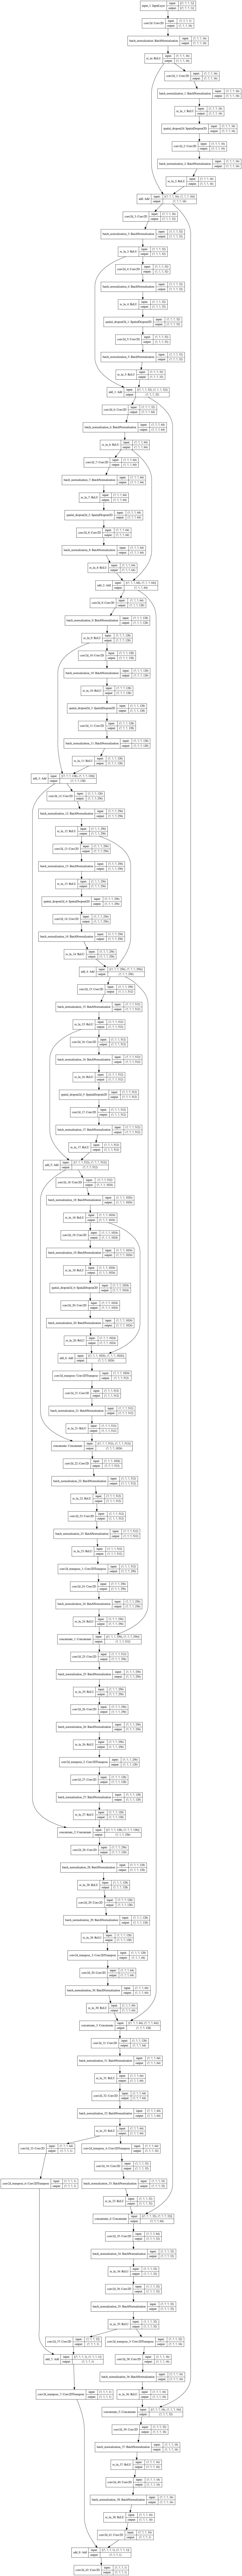

In [18]:
%%time

from trainer import model

# Copy the model from storage to local memory
!gsutil -m cp -r $best_model_dir_pyth* ./model_dir

# Load the model
loaded_model = tf.keras.models.load_model('./model_dir', compile=False, 
               custom_objects={"custom_loss": model.custom_loss, "custom_mse": model.custom_mse})
print("Signature ", loaded_model.signatures)
print("")

# Display model
tf.keras.utils.plot_model(loaded_model, show_shapes=True)


------
# Training

In [33]:
# Create the config directory and load the trainer files in it
!mkdir -p config


In [34]:
%%writefile ./config/config.yaml

# python3
# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================

# https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training#--scale-tier
# https://www.kaggle.com/c/passenger-screening-algorithm-challenge/discussion/37087
# https://cloud.google.com/ai-platform/training/docs/using-gpus

#trainingInput:
#  scaleTier: CUSTOM
#  masterType: n1-highmem-8
#  masterConfig:
#    acceleratorConfig:
#      count: 1
#      type: NVIDIA_TESLA_T4

#  masterType: n1-highcpu-16
#  workerType: cloud_tpu
#  workerCount: 1
#  workerConfig:
#    acceleratorConfig:
#      type: TPU_V3
#      count: 8

#trainingInput:
#  scaleTier: CUSTOM
#  masterType: complex_model_m
#  workerType: complex_model_m
#  parameterServerType: large_model
#  workerCount: 6
#  parameterServerCount: 1
#  scheduling:
#    maxWaitTime: 3600s
#    maxRunningTime: 7200s

#trainingInput:
#  runtimeVersion: "2.2"
#  scaleTier: CUSTOM
#  masterType: standard_gpu
#  workerCount: 9
#  workerType: standard_gpu
#  parameterServerCount: 3
#  parameterServerType: standard

#trainingInput:
#  scaleTier: BASIC-GPU
    
#trainingInput:
#  region: us-central1
#  scaleTier: CUSTOM
#  masterType: complex_model_m
#  workerType: complex_model_m_gpu
#  parameterServerType: large_model
#  workerCount: 4
#  parameterServerCount: 2

trainingInput:
    scaleTier: CUSTOM
    masterType: n1-highmem-16
    masterConfig:
        acceleratorConfig:
            count: 2
            type: NVIDIA_TESLA_V100



Overwriting ./config/config.yaml


In [35]:
from datetime import datetime
from pytz import timezone
JOBNAME_TRN = 'tf_train_'+ USER + '_' + \
           datetime.now(timezone('US/Pacific')).strftime("%m%d%y_%H%M")
JOB_CONFIG = "config/config.yaml"
MODEL_DIR_TRN = MODEL_DIR + datetime.now(timezone('US/Pacific')).strftime('/model_%m%d%Y_%H%M')
print("Job Name = ", JOBNAME_TRN)
print("Job Dir  = ", JOB_DIR)
print("MODEL_DIR =", MODEL_DIR_TRN)

# Training parameters
DEPTH = 6
DROPOUT_RATE = 0.15
N_SEG_LEVELS = 3
N_BASE_FILTERS = 16
#DEPTH = 5
#DROPOUT_RATE = 0.2
#N_SEG_LEVELS = 3
LEARNING_RATE = 0.00005
EPOCHS = 2
BATCH_SIZE = 1
NUM_SAMPLES = 3000

print('DEPTH = %02d' % DEPTH)
print('DROPOUT_RATE = %.4f' % DROPOUT_RATE)
print('N_SEG_LEVELS = %02d' % N_SEG_LEVELS)
print('N_BASE_FILTERS = %02d' % N_BASE_FILTERS)
print('LEARNING_RATE = %.6f' % LEARNING_RATE)
print('EPOCHS = %02d' % EPOCHS)
print('BATCH_SIZE = %02d' % BATCH_SIZE)
print('NUM_SAMPLES = %d' % NUM_SAMPLES)


Job Name =  tf_train_cchatterj_122020_2303
Job Dir  =  gs://chanchal-sandbox/ht-tf-data/jobdir
MODEL_DIR = gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2303
DEPTH = 06
DROPOUT_RATE = 0.1500
N_SEG_LEVELS = 03
N_BASE_FILTERS = 16
LEARNING_RATE = 0.000050
EPOCHS = 02
BATCH_SIZE = 01
NUM_SAMPLES = 3000


In [36]:
# https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training

TRAIN_LABELS = "mode=train,owner="+USER

# submit the training job
! gcloud ai-platform jobs submit training $JOBNAME_TRN \
  --package-path $(pwd)/trainer \
  --module-name trainer.train \
  --region $REGION \
  --python-version 3.7 \
  --runtime-version $RUNTIME_VERSION \
  --job-dir $JOB_DIR \
  --config $JOB_CONFIG \
  --labels $TRAIN_LABELS \
  -- \
  --depth=$DEPTH \
  --dropout_rate=$DROPOUT_RATE \
  --n_segmentation_levels=$N_SEG_LEVELS \
  --learning_rate=$LEARNING_RATE \
  --epochs=$EPOCHS \
  --batch_size=$BATCH_SIZE \
  --num_samples=$NUM_SAMPLES \
  --model_dir=$MODEL_DIR_TRN


Job [tf_train_cchatterj_122020_2303] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe tf_train_cchatterj_122020_2303

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs tf_train_cchatterj_122020_2303
jobId: tf_train_cchatterj_122020_2303
state: QUEUED


In [38]:
# check the training job status
! gcloud ai-platform jobs describe $JOBNAME_TRN


createTime: '2020-12-21T07:03:43Z'
endTime: '2020-12-21T07:32:11Z'
etag: nrP4bj3OIrI=
jobId: tf_train_cchatterj_122020_2303
labels:
  mode: train
  owner: cchatterj
startTime: '2020-12-21T07:06:08Z'
state: SUCCEEDED
trainingInput:
  args:
  - --depth=6
  - --dropout_rate=0.15
  - --n_segmentation_levels=3
  - --learning_rate=5e-05
  - --epochs=2
  - --batch_size=1
  - --num_samples=3000
  - --model_dir=gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2303
  jobDir: gs://chanchal-sandbox/ht-tf-data/jobdir
  masterConfig:
    acceleratorConfig:
      count: '2'
      type: NVIDIA_TESLA_V100
  masterType: n1-highmem-16
  packageUris:
  - gs://chanchal-sandbox/ht-tf-data/jobdir/packages/bc47beb5f709dd04617ee921bad4a206549f9af9b6102c124b71136fef0fad0e/trainer-0.1.tar.gz
  pythonModule: trainer.train
  pythonVersion: '3.7'
  region: us-central1
  runtimeVersion: '2.1'
  scaleTier: CUSTOM
trainingOutput:
  consumedMLUnits: 4.82

View job in the Cloud Console at:
https://console.cloud.go

In [39]:
# Print Errors
response = ! gcloud logging read "resource.labels.job_id=$JOBNAME_TRN severity>=ERROR"
for i in range(0,len(response)):
    if 'message' in response[i]:
        print(response[i])

  message: You should consider upgrading via the '/usr/local/bin/python3 -m pip install
  message: 'WARNING: You are using pip version 20.1; however, version 20.3.3 is available.'
  message: '  Consider adding this directory to PATH or, if you prefer to suppress
  message: "  WARNING: The scripts estimator_ckpt_converter, saved_model_cli, tensorboard,\
  message: You should consider upgrading via the '/usr/local/bin/python3 -m pip install
  message: 'WARNING: You are using pip version 20.1; however, version 20.3.3 is available.'


In [40]:
# Test with latest saved model
best_model_dir_trn = find_best_model_dir(MODEL_DIR_TRN+'/checkpoints', offset=1, maxFlag=0)
#acc = test_saved_model(best_model_dir_trn, 0)



All Models = 
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2303/checkpoints/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2303/checkpoints/cp-232608-0-0.0284/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2303/checkpoints/cp-232608-0-0.0470/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2303/checkpoints/cp-232608-0-0.0470/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2303/checkpoints/cp-232608-0-0.0284/
Best Accuracy  from Checkpoints =  0.0284
Best Model Dir from Checkpoints =  gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2303/checkpoints/cp-232608-0-0.0284/


------
# Hyper Parameter Tuning

In [41]:
# Create the tf directory and load the trainer files in it
!cp ./trainer/train.py ./trainer/train_hpt.py


In [42]:
%%writefile -a ./trainer/train_hpt.py

    """This method updates a CAIP HPTuning Job with a final metric for the job.
    In TF2.X the user must either use hypertune or a custom callback with
    tf.summary.scalar to update CAIP HP Tuning jobs. This function uses
    hypertune, which appears to be the preferred solution. Hypertune also works
    with containers, without code change.
    Args:
        metric_tag: The metric being optimized.  This MUST MATCH the
          hyperparameterMetricTag specificed in the hyperparameter tuning yaml.
        metric_value: The value to report at the end of model training.
        global_step: An int value to specify the number of trainin steps completed
          at the time the metric was reported.
    """

    hpt = hypertune.HyperTune()
    hpt.report_hyperparameter_tuning_metric(
        hyperparameter_metric_tag='custom_mse',
        metric_value=final_epoch_accuracy,
        global_step=final_epoch_count
    )


Appending to ./trainer/train_hpt.py


In [43]:
%%writefile ./config/hptuning_config.yaml

# python3
# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================

# https://cloud.google.com/ai-platform/training/docs/reference/rest/v1/projects.jobs

#trainingInput:
#  scaleTier: CUSTOM
#  masterType: n1-highmem-8
#  masterConfig:
#    acceleratorConfig:
#      count: 1
#      type: NVIDIA_TESLA_T4
#
#  masterType: standard_p100
#  workerType: standard_p100
#  parameterServerType: standard_p100
#  workerCount: 8
#  parameterServerCount: 1
#  runtimeVersion: $RUNTIME_VERSION
#  pythonVersion: '3.7'

#trainingInput:
#  scaleTier: CUSTOM
#  masterType: complex_model_m
#  workerType: complex_model_m
#  parameterServerType: large_model
#  workerCount: 9
#  parameterServerCount: 3
#  scheduling:
#    maxWaitTime: 3600s
#    maxRunningTime: 7200s

#trainingInput:
#  scaleTier: BASIC-GPU

trainingInput:
  scaleTier: CUSTOM
  masterType: n1-highmem-16
  masterConfig:
    acceleratorConfig:
      count: 2
      type: NVIDIA_TESLA_V100
  hyperparameters:
    goal: MAXIMIZE
    hyperparameterMetricTag: custom_mse
    maxTrials: 32
    maxParallelTrials: 4
    enableTrialEarlyStopping: True
    params:
    - parameterName: depth
      type: INTEGER
      minValue: 4
      maxValue: 6
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: dropout_rate
      type: DOUBLE
      minValue: 0.1
      maxValue: 0.3
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: n_segmentation_levels
      type: DISCRETE
      discreteValues:
      - 2
      - 3
    - parameterName: n_base_filters
      type: DISCRETE
      discreteValues:
      - 8
      - 12
      - 16


Overwriting ./config/hptuning_config.yaml


In [44]:
from datetime import datetime
from pytz import timezone

JOBNAME_HPT = 'tf_hptrn_' + USER + '_' + \
              datetime.now(timezone('US/Pacific')).strftime("%m%d%y_%H%M")
JOB_CONFIG = "./config/hptuning_config.yaml"
MODEL_DIR_HPT = MODEL_DIR + datetime.now(timezone('US/Pacific')).strftime('/model_%m%d%Y_%H%M')
print("Job Name = ", JOBNAME_HPT)
print("Job Dir  = ", JOB_DIR)
print("MODEL_DIR =", MODEL_DIR_HPT)

# Training parameters
LEARNING_RATE = 0.00005
EPOCHS = 2
BATCH_SIZE = 1
NUM_SAMPLES = 3000

print('LEARNING_RATE = %.6f' % LEARNING_RATE)
print('EPOCHS = %02d' % EPOCHS)
print('BATCH_SIZE = %02d' % BATCH_SIZE)
print('NUM_SAMPLES = %d' % NUM_SAMPLES)


Job Name =  tf_hptrn_cchatterj_122020_2339
Job Dir  =  gs://chanchal-sandbox/ht-tf-data/jobdir
MODEL_DIR = gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339
LEARNING_RATE = 0.000050
EPOCHS = 02
BATCH_SIZE = 01
NUM_SAMPLES = 3000


In [45]:
# submit the training job
HT_LABELS = "mode=hypertrain,owner="+USER

! gcloud ai-platform jobs submit training $JOBNAME_HPT \
  --package-path $(pwd)/trainer \
  --module-name trainer.train_hpt \
  --python-version 3.7 \
  --runtime-version $RUNTIME_VERSION \
  --region $REGION \
  --job-dir $JOB_DIR \
  --config $JOB_CONFIG \
  --labels $HT_LABELS \
  -- \
  --learning_rate=$LEARNING_RATE \
  --epochs=$EPOCHS \
  --batch_size=$BATCH_SIZE \
  --num_samples=$NUM_SAMPLES \
  --model_dir=$MODEL_DIR_HPT


Job [tf_hptrn_cchatterj_122020_2339] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe tf_hptrn_cchatterj_122020_2339

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs tf_hptrn_cchatterj_122020_2339
jobId: tf_hptrn_cchatterj_122020_2339
state: QUEUED


In [46]:
# check the hyperparameter training job status
! gcloud ai-platform jobs describe $JOBNAME_HPT


createTime: '2020-12-21T07:39:43Z'
endTime: '2020-12-21T11:04:25Z'
etag: jj80eOqRbh4=
jobId: tf_hptrn_cchatterj_122020_2339
labels:
  mode: hypertrain
  owner: cchatterj
startTime: '2020-12-21T07:39:46Z'
state: SUCCEEDED
trainingInput:
  args:
  - --learning_rate=5e-05
  - --epochs=2
  - --batch_size=1
  - --num_samples=3000
  - --model_dir=gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339
  hyperparameters:
    enableTrialEarlyStopping: true
    goal: MAXIMIZE
    hyperparameterMetricTag: custom_mse
    maxParallelTrials: 4
    maxTrials: 32
    params:
    - maxValue: 6.0
      minValue: 4.0
      parameterName: depth
      scaleType: UNIT_LINEAR_SCALE
      type: INTEGER
    - maxValue: 0.3
      minValue: 0.1
      parameterName: dropout_rate
      scaleType: UNIT_LINEAR_SCALE
      type: DOUBLE
    - discreteValues:
      - 2.0
      - 3.0
      parameterName: n_segmentation_levels
      type: DISCRETE
    - discreteValues:
      - 8.0
      - 12.0
      - 16.0
      par

In [ ]:
# Print Errors
response = ! gcloud logging read "resource.labels.job_id=$JOBNAME_HPT severity>=ERROR"
for i in range(0,len(response)):
    if 'message' in response[i]:
        print(response[i])

In [47]:
# Get the best model parameters from Cloud API
best_model = pyth_get_hypertuned_parameters(PROJECT_ID, JOBNAME_HPT, 0)
DEPTH = best_model['hyperparameters']['depth']
DROPOUT_RATE = best_model['hyperparameters']['dropout_rate']
N_SEG_LEVELS = best_model['hyperparameters']['n_segmentation_levels']
N_BASE_FILTERS = best_model['hyperparameters']['n_base_filters']
print('')
print('Objective=', best_model['finalMetric']['objectiveValue'])
print('DEPTH =', DEPTH)
print('DROPOUT_RATE =', DROPOUT_RATE)
print('N_SEG_LEVELS =', N_SEG_LEVELS)
print('N_BASE_FILTERS =', N_BASE_FILTERS)


objective= 0.08708462864160538  trialId= 25 SUCCEEDED
     depth 4
     dropout_rate 0.3
     n_base_filters 8
     n_segmentation_levels 2
objective= 0.07977455109357834  trialId= 4 SUCCEEDED
     depth 6
     dropout_rate 0.20904205279535681
     n_base_filters 8
     n_segmentation_levels 2
objective= 0.0786379873752594  trialId= 9 SUCCEEDED
     depth 6
     dropout_rate 0.20904205279535681
     n_base_filters 8
     n_segmentation_levels 2
objective= 0.07795991003513336  trialId= 6 SUCCEEDED
     depth 6
     dropout_rate 0.13112627382797257
     n_base_filters 8
     n_segmentation_levels 3
objective= 0.0723678469657898  trialId= 14 SUCCEEDED
     depth 6
     dropout_rate 0.3
     n_base_filters 8
     n_segmentation_levels 3
objective= 0.0706782415509224  trialId= 15 SUCCEEDED
     depth 4
     dropout_rate 0.3
     n_base_filters 12
     n_segmentation_levels 3
objective= 0.06671430170536041  trialId= 18 SUCCEEDED
     depth 4
     dropout_rate 0.3
     n_base_filters 8
     n

In [48]:
# Find count of checkpoints
all_models = ! gsutil ls {MODEL_DIR_HPT+'/checkpoints'}
print("Total Hypertrained Models=", len(all_models))

# Test with latest saved model
best_model_dir_hyp = find_best_model_dir(MODEL_DIR_HPT+'/checkpoints', offset=1, maxFlag=0)
#acc = test_saved_model(best_model_dir_hyp, 0)

#import keras.backend as K
#loaded_model = tf.keras.models.load_model(MODEL_DIR_PARAM+'/checkpoints')
#print("learning_rate=", K.eval(loaded_model.optimizer.lr))
#tf.keras.utils.plot_model(loaded_model, show_shapes=True)


Total Hypertrained Models= 65

All Models = 
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-002308-5-0.0653/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-002308-5-0.1317/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-002308-6-0.0780/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-002308-6-0.1368/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-002308-7-0.0351/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-002308-7-0.0785/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-002308-8-0.0390/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-002308-8-0.0854/
gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-004800-10-0.0314/
gs://chanchal-sandbox/ht-tf-data/models/model_1220202

--------
# Deploy the Model

In [49]:
## https://cloud.google.com/ai-platform/prediction/docs/machine-types-online-prediction#available_machine_types
# We need 2 versions of the same model:
# 1. Batch prediction model deployed on a mls1-c1-m2 cluster
# 2. Online prediction model deployed on a n1-standard-16 cluster
# Batch prediction does not support GPU and n1-standard-16 clusters.

# Run the Deploy Model section twice:
# 1. As a BATCH Mode version use MODEL_VERSION = MODEL_VERSION_BATCH
# 2. As a ONLINE Mode version use MODEL_VERSION = MODEL_VERSION_ONLINE


In [50]:
from googleapiclient import discovery
from googleapiclient import errors
import time
import yaml

def print_all_versions_of_model(project_id, model_name):
    project_id = 'projects/{}'.format(project_id)
    model_id = '{}/models/{}'.format(project_id, model_name)
    credentials = GoogleCredentials.get_application_default()
    service = discovery.build('ml', 'v1', cache_discovery=False, credentials=credentials)
    request = service.projects().models().versions().list(parent=model_id)
    response = request.execute()

    # check if model has versions
    all_versions = []
    if 'versions' in response.keys():    
        all_versions = response['versions']

    # print all model versions
    print("\nVersions for Model:", model_name)
    print("Total Number of versions = ", len(all_versions))
    if (len(all_versions) > 0):
        print("")
        print(yaml.dump(all_versions))
    
    return all_versions

#------------------------------------------------------------------------------#
def delete_model_versions(project_id, model_name, version_name):
    project_id = 'projects/{}'.format(project_id)
    model_id = '{}/models/{}'.format(project_id, model_name)
    credentials = GoogleCredentials.get_application_default()
    service = discovery.build('ml', 'v1', cache_discovery=False, credentials=credentials)

    # get model versions
    all_versions = print_all_versions_of_model(PROJECT_ID, MODEL_NAME)

    # check if current version is a default version
    cur_ver_default = 0
    for i in range(len(all_versions)):
        if MODEL_VERSION in all_versions[i]['name']:
            if 'isDefault' in all_versions[i].keys():
                if all_versions[i]['isDefault'] == True:
                    cur_ver_default = 1
    print("cur_ver_default=", cur_ver_default)

    # if not default delete this version only
    if (cur_ver_default == 0) and (len(all_versions) > 0):
        print("This is not the default version")
        print("Delete only this version")
        for i in range(len(all_versions)):
            if MODEL_VERSION in all_versions[i]['name']:
                print("Deleting non default version:", version['name'])
                request = service.projects().models().versions().delete(name = all_versions[i]['name'])
                try:
                    request.execute()
                except errors.HttpError as err:
                    reason = err._get_reason()
                    print("Delete Error Reason:", reason)

    if (cur_ver_default == 1) and (len(all_versions) > 0):
        print("This is the default version")
        print("Delete all versions")
        if (cur_ver_default == 1) and (len(all_versions) > 0):
            print("This is the default version")
            print("Delete all versions")
            while len(all_versions) >= 1:
                for version in all_versions:
                    #print("Deleting version:", version['name'])
                    request = service.projects().models().versions().delete(name = version['name'])
                    try:
                        request.execute()
                    except errors.HttpError as err:
                        reason = err._get_reason()
                        #print("Delete Error Reason:", reason)
                        if 'Cannot delete the default version' in reason:
                            next
                request = service.projects().models().versions().list(parent=model_id)
                response = request.execute()
                time.sleep(1)
                try:
                    all_versions = response['versions']
                except:
                    all_versions = []
                    break

In [73]:
MODEL_NAME = "unetfpn16sl1"
MODEL_VERSION_BATCH  = "cchatterj_v1_batch"
MODEL_VERSION_ONLINE = "cchatterj_v1_online"

#Run this as Batch first then Online
MODEL_VERSION = MODEL_VERSION_BATCH
#MODEL_VERSION = MODEL_VERSION_ONLINE

# List all models
print("\nList all models")
!gcloud ai-platform models list

# List all versions of the model
#!gcloud ai-platform versions list --model $MODEL_NAME
_ = print_all_versions_of_model(PROJECT_ID, MODEL_NAME)



List all models
Using endpoint [https://ml.googleapis.com/]
NAME               DEFAULT_VERSION_NAME
flip_unetfpn16sl2  cchatterj_v1
unetfpn16sl1       cchatterj_v1_batch
xgb_model          cchatterj_xgb_bst

Versions for Model: unetfpn16sl1
Total Number of versions =  2

- createTime: '2020-12-21T16:39:04Z'
  deploymentUri: gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-025109-29-0.0283/
  description: UNET_FPN_SL1
  etag: QlMHCevC6gk=
  framework: TENSORFLOW
  isDefault: true
  labels:
    mode: batch
    owner: cchatterj
    phase: test
    team: total
  lastUseTime: '2020-12-21T16:43:02Z'
  machineType: mls1-c1-m2
  name: projects/codev-257422/models/unetfpn16sl1/versions/cchatterj_v1_batch
  pythonVersion: '3.7'
  runtimeVersion: '2.1'
  state: READY
- createTime: '2020-12-21T16:40:46Z'
  deploymentUri: gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-025109-29-0.0283/
  description: UNET_FPN_SL1
  etag: 83bpi33ShyI=
  framewor

In [58]:
#!gcloud ai-platform versions delete $MODEL_VERSION --model $MODEL_NAME -q
#!gcloud ai-platform models delete $MODEL_NAME -q


In [59]:
# create the model if it doesn't already exist
modelname = !gcloud ai-platform models list | grep -w $MODEL_NAME
print(modelname)
if len(modelname) <= 1:
    print("Creating model " + MODEL_NAME)
    ! gcloud ai-platform models create $MODEL_NAME --regions $REGION --enable-logging
else:
    print("Model " + MODEL_NAME + " exist")


['Using endpoint [https://ml.googleapis.com/]', 'unetfpn16sl1       cchatterj_v1_batch']
Model unetfpn16sl1 exist


In [60]:
# Check if current version is default
#    if default model delete all versions
#    if not default model delete only this version

print("Model Version=", MODEL_VERSION)
delete_model_versions(PROJECT_ID, MODEL_NAME, MODEL_VERSION)

# List the models
print("\nList all models:")
!gcloud ai-platform models list

# List all versions of the model
_ = print_all_versions_of_model(PROJECT_ID, MODEL_NAME)
#!gcloud ai-platform versions list --model $MODEL_NAME


Model Version= cchatterj_v1_online

Versions for Model: unetfpn16sl1
Total Number of versions =  1

- createTime: '2020-12-21T16:39:04Z'
  deploymentUri: gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-025109-29-0.0283/
  description: UNET_FPN_SL1
  etag: QlMHCevC6gk=
  framework: TENSORFLOW
  isDefault: true
  labels:
    mode: batch
    owner: cchatterj
    phase: test
    team: total
  machineType: mls1-c1-m2
  name: projects/codev-257422/models/unetfpn16sl1/versions/cchatterj_v1_batch
  pythonVersion: '3.7'
  runtimeVersion: '2.1'
  state: READY

cur_ver_default= 0
This is not the default version
Delete only this version

List all models:
Using endpoint [https://ml.googleapis.com/]
NAME               DEFAULT_VERSION_NAME
flip_unetfpn16sl2  cchatterj_v1
unetfpn16sl1       cchatterj_v1_batch
xgb_model          cchatterj_xgb_bst

Versions for Model: unetfpn16sl1
Total Number of versions =  1

- createTime: '2020-12-21T16:39:04Z'
  deploymentUri: gs://chancha

In [61]:
%%time

# Get a list of model directories
best_model_dir = best_model_dir_hyp  #best_model_dir_hyp
print("Best Model Dir: ", best_model_dir)

MODEL_FRAMEWORK = "TENSORFLOW"
MODEL_DESCRIPTION = "UNET_FPN_SL1"
MODEL_LABELS="team=total,phase=test,owner="+USER

MACHINE_TYPE = "mls1-c1-m2"
if (MODEL_VERSION == MODEL_VERSION_BATCH):
    MACHINE_TYPE = "mls1-c1-m2"
    MODEL_LABELS = MODEL_LABELS+",mode=batch"
if (MODEL_VERSION == MODEL_VERSION_ONLINE):
    MACHINE_TYPE = "n1-standard-16"
    MODEL_LABELS = MODEL_LABELS+",mode=online"

# Deploy the model
! gcloud beta ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --origin $best_model_dir \
  --runtime-version $RUNTIME_VERSION \
  --python-version=3.7 \
  --description=$MODEL_DESCRIPTION \
  --labels $MODEL_LABELS \
  --machine-type=$MACHINE_TYPE 
#  --framework $MODEL_FRAMEWORK \
#  --region=$REGION


Best Model Dir:  gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-025109-29-0.0283/
Using endpoint [https://ml.googleapis.com/]
Creating version (this might take a few minutes)......done.                    
CPU times: user 776 ms, sys: 280 ms, total: 1.06 s
Wall time: 53.4 s


In [74]:
# List all models
print("")
!gcloud ai-platform models list

# List a ll versions of model
_ = print_all_versions_of_model(PROJECT_ID, MODEL_NAME)



Using endpoint [https://ml.googleapis.com/]
NAME               DEFAULT_VERSION_NAME
flip_unetfpn16sl2  cchatterj_v1
unetfpn16sl1       cchatterj_v1_batch
xgb_model          cchatterj_xgb_bst

Versions for Model: unetfpn16sl1
Total Number of versions =  2

- createTime: '2020-12-21T16:39:04Z'
  deploymentUri: gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-025109-29-0.0283/
  description: UNET_FPN_SL1
  etag: QlMHCevC6gk=
  framework: TENSORFLOW
  isDefault: true
  labels:
    mode: batch
    owner: cchatterj
    phase: test
    team: total
  lastUseTime: '2020-12-21T16:43:02Z'
  machineType: mls1-c1-m2
  name: projects/codev-257422/models/unetfpn16sl1/versions/cchatterj_v1_batch
  pythonVersion: '3.7'
  runtimeVersion: '2.1'
  state: READY
- createTime: '2020-12-21T16:40:46Z'
  deploymentUri: gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-025109-29-0.0283/
  description: UNET_FPN_SL1
  etag: 83bpi33ShyI=
  framework: TENSORFLOW
  

------
# Predictions with the deployed model

Input and pre-process data ...
Data  Shape =  (16, 256, 256, 1)
Label Shape =  (16, 256, 256, 1)
X_test shape = (16, 256, 256, 1)


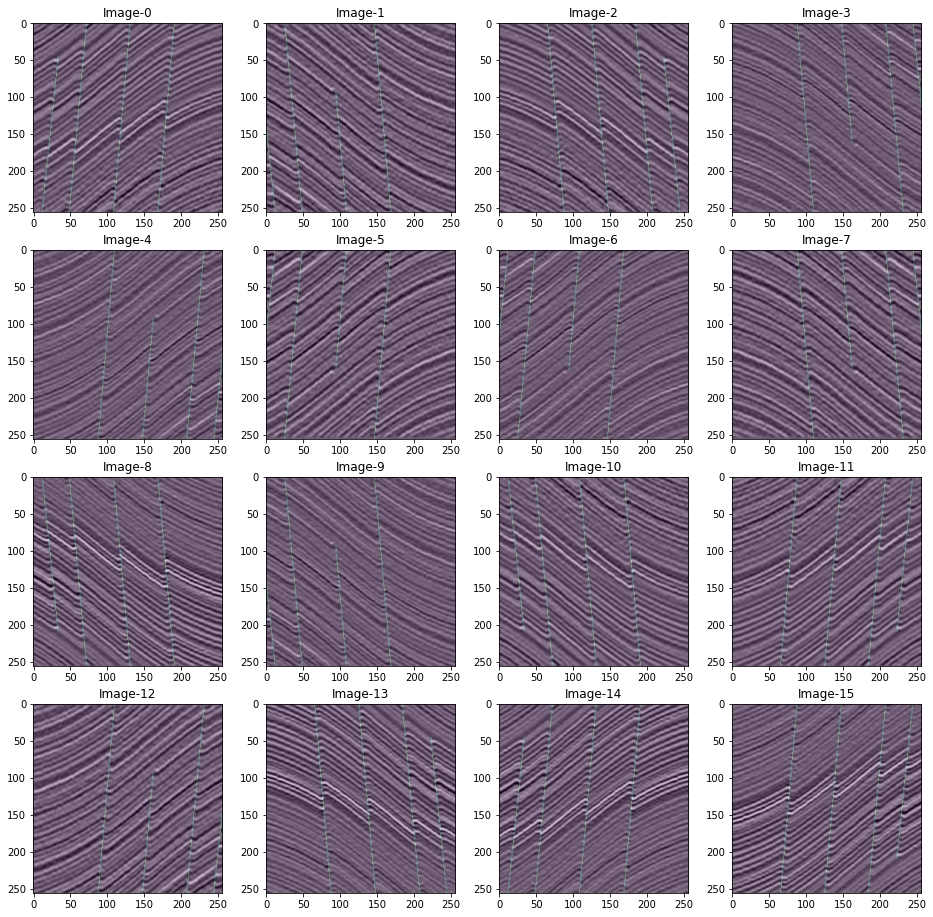

In [63]:
from trainer import inputs
print("Input and pre-process data ...")
# Extract train_seismic, train_label
data_dir = 'gs://codev-test-data/FAULT_TRAINING_SET/SYNTHETIC_OPTIM/seismic'
label_dir = 'gs://codev-test-data/FAULT_TRAINING_SET/SYNTHETIC_OPTIM/label'
test_dataset = inputs.load_data(data_dir, label_dir, range(0,16), 1)
X_test1 = list(test_dataset.as_numpy_iterator())
X_test1 = np.array(X_test1).astype(dtype='float32')
X_test_images = X_test1[:,0,0,:,:,:]
X_test_labels = X_test1[:,1,0,:,:,:]

print("X_test shape =", X_test_images.shape)

# plot the results
plot_images(X_test_images[:,:,:,0], X_test_labels[:,:,:,0])


In [64]:
%%time

from trainer import model

# Copy the model from storage to local memory
!gsutil -m cp -r $best_model_dir_hyp* ./model_dir

# Load the model
loaded_model = tf.keras.models.load_model('./model_dir', compile=False, 
               custom_objects={"custom_loss": model.custom_loss,"custom_mse": model.custom_mse})
print("Signature ", loaded_model.signatures)

# Check the model layers
model_layers = [layer.name for layer in loaded_model.layers]
print("")
print("Model Input  Layer=", model_layers[0])
print("Model Output Layer=", model_layers[-1])
print("")


Copying gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-025109-29-0.0283/saved_model.pb...
Copying gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-025109-29-0.0283/variables/variables.data-00000-of-00002...
Copying gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-025109-29-0.0283/variables/variables.data-00001-of-00002...
Copying gs://chanchal-sandbox/ht-tf-data/models/model_12202020_2339/checkpoints/cp-025109-29-0.0283/variables/variables.index...
Signature  _SignatureMap({'serving_default': <tensorflow.python.saved_model.load._WrapperFunction object at 0x7fc8982ad5d0>})

Model Input  Layer= input_1
Model Output Layer= conv2d_29

CPU times: user 5.26 s, sys: 220 ms, total: 5.48 s
Wall time: 7.83 s


## Batch Prediction with GCLOUD

In [65]:
# Write batch data to file in GCS

import shutil

# Clean current directory
DATA_DIR = './batch_data'
shutil.rmtree(DATA_DIR, ignore_errors=True)
os.makedirs(DATA_DIR)

nTotalImages = X_test_images.shape[0]
nFiles = min(100,nTotalImages)
nImagesPerFile = min(100, nTotalImages//nFiles)
print("nTotalImages =", nTotalImages)
print("nFiles =", nFiles)
print("nImagesPerFile =", nImagesPerFile)

# Create nFiles files with nImagesPerFile images each
for i in range(nFiles):
    with open(f'{DATA_DIR}/unkeyed_batch_{i}.json', "w") as file:
        for z in range(nImagesPerFile):
            print(f'{{"{model_layers[0]}": {X_test_images[i*nImagesPerFile+z].tolist()}}}', file=file)
            #key = f'key_{i}_{z}'
            #print(f'{{"image": {X_test_images[z].tolist()}, "key": "{key}"}}', file=file)

# Write batch data to file
! gsutil -m cp -r ./batch_data gs://$BUCKET_NAME/$FOLDER_NAME/


nTotalImages = 16
nFiles = 16
nImagesPerFile = 1
Copying file://./batch_data/unkeyed_batch_10.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_2.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_1.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_11.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_6.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_5.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_14.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_0.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_9.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_4.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_13.json [Content-Type=application/json]...
Copying file://./batch_

In [66]:
from datetime import datetime
from pytz import timezone

DATA_FORMAT="text" # JSON data format
INPUT_PATHS='gs://' + BUCKET_NAME + '/' + FOLDER_NAME + '/batch_data/*'
OUTPUT_PATH='gs://' + BUCKET_NAME + '/' + FOLDER_NAME + '/batch_predictions'
PRED_LABELS="mode=batch,team=engineering,phase=test,owner="+USER
SIGNATURE_NAME="serving_default"

JOBNAME_BATCH = 'tf_batch_predict_'+ USER + '_' + \
           datetime.now(timezone('US/Pacific')).strftime("%m%d%y_%H%M")

print("INPUT_PATHS = ", INPUT_PATHS)
print("OUTPUT_PATH = ", OUTPUT_PATH)
print("Job Name    = ", JOBNAME_BATCH)


INPUT_PATHS =  gs://chanchal-sandbox/ht-tf-data/batch_data/*
OUTPUT_PATH =  gs://chanchal-sandbox/ht-tf-data/batch_predictions
Job Name    =  tf_batch_predict_cchatterj_122120_0842


In [67]:
# Submit batch predict job
# Use  MODEL_VERSION_BATCH not MODEL_VERSION_ONLINE
MODEL_VERSION = MODEL_VERSION_BATCH

! gcloud ai-platform jobs submit prediction $JOBNAME_BATCH \
    --model $MODEL_NAME \
    --version $MODEL_VERSION \
    --input-paths $INPUT_PATHS \
    --output-path $OUTPUT_PATH \
    --region $REGION \
    --data-format $DATA_FORMAT \
    --labels $PRED_LABELS \
    --signature-name $SIGNATURE_NAME


Job [tf_batch_predict_cchatterj_122120_0842] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe tf_batch_predict_cchatterj_122120_0842

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs tf_batch_predict_cchatterj_122120_0842
jobId: tf_batch_predict_cchatterj_122120_0842
state: QUEUED


In [68]:
# check the batch prediction job status
! gcloud ai-platform jobs describe $JOBNAME_BATCH


createTime: '2020-12-21T16:43:01Z'
endTime: '2020-12-21T16:49:57Z'
etag: oisluZlFoAc=
jobId: tf_batch_predict_cchatterj_122120_0842
labels:
  mode: batch
  owner: cchatterj
  phase: test
  team: engineering
predictionInput:
  dataFormat: JSON
  inputPaths:
  - gs://chanchal-sandbox/ht-tf-data/batch_data/*
  outputPath: gs://chanchal-sandbox/ht-tf-data/batch_predictions
  region: us-central1
  runtimeVersion: '2.1'
  signatureName: serving_default
  versionName: projects/codev-257422/models/unetfpn16sl1/versions/cchatterj_v1_batch
predictionOutput:
  nodeHours: 0.12
  outputPath: gs://chanchal-sandbox/ht-tf-data/batch_predictions
  predictionCount: '16'
startTime: '2020-12-21T16:43:02Z'
state: SUCCEEDED

View job in the Cloud Console at:
https://console.cloud.google.com/mlengine/jobs/tf_batch_predict_cchatterj_122120_0842?project=codev-257422

View logs at:
https://console.cloud.google.com/logs?resource=ml_job%2Fjob_id%2Ftf_batch_predict_cchatterj_122120_0842&project=codev-257422


In [69]:
# Print Errors
response = ! gcloud logging read "resource.labels.job_id=$JOBNAME_BATCH severity>=ERROR"
for i in range(0,len(response)):
    if 'message' in response[i]:
        print(response[i])


In [ ]:
!gsutil cat $OUTPUT_PATH/prediction.results-00000-of-00016


## Online Prediction with python

In [77]:
%%time

# Use MODEL_VERSION_ONLINE not MODEL_VERSION_BATCH
MODEL_VERSION = MODEL_VERSION_ONLINE

from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors
import json

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#tf.get_logger().setLevel('ERROR')

project_id = 'projects/{}'.format(PROJECT_ID)
model_name = '{}/models/{}'.format(project_id, MODEL_NAME)
if MODEL_VERSION is not None:
    model_name += '/versions/{}'.format(MODEL_VERSION)
credentials = GoogleCredentials.get_application_default()
service = discovery.build('ml', 'v1', cache_discovery=False, credentials=credentials)

pprobas_temp = []
batch_size = 1
n_samples = min(1000,len(X_test_images))
print("n_samples=", n_samples)
for i in range(0, n_samples, batch_size):
    j = min(i+batch_size, n_samples)
    print("Processing samples", i, j)
    request = service.projects().predict(name=model_name, \
                                         body={'instances': X_test_images[i:j].tolist()})
    try:
        response = request.execute()
    except errors.HttpError as err:
        # Something went wrong, print out some information.
        tf.compat.v1.logging.error('There was an error getting the job info, Check the details:')
        tf.compat.v1.logging.error(err._get_reason())

    pprobas_temp += response['predictions']



n_samples= 16
Processing samples 0 1
Processing samples 1 2
Processing samples 2 3
Processing samples 3 4
Processing samples 4 5
Processing samples 5 6
Processing samples 6 7
Processing samples 7 8
Processing samples 8 9
Processing samples 9 10
Processing samples 10 11
Processing samples 11 12
Processing samples 12 13
Processing samples 13 14
Processing samples 14 15
Processing samples 15 16
CPU times: user 4.58 s, sys: 76 ms, total: 4.66 s
Wall time: 44.4 s


Online Version is Used
pprobas shape= (16, 256, 256)


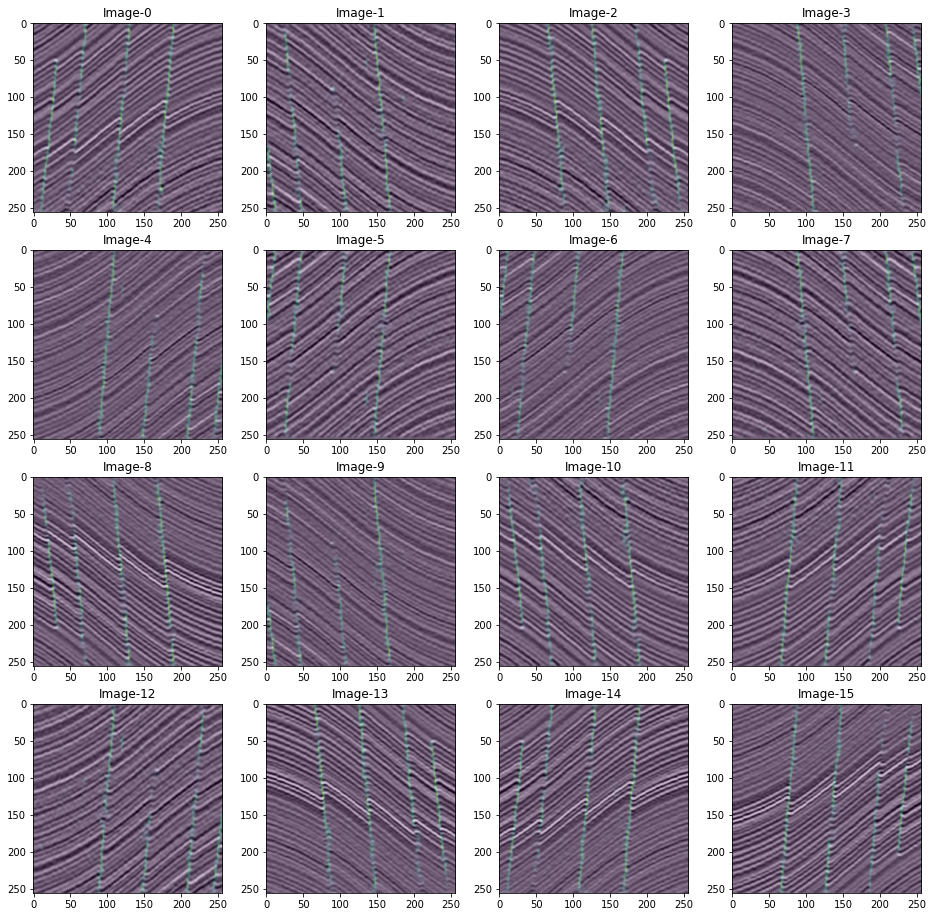

In [72]:
# If Model Version Online is used
if (MODEL_VERSION_ONLINE in model_name):
    print("Online Version is Used")
    pprobas = np.array(pprobas_temp)[:,:,:,0]
    print("pprobas shape=", pprobas.shape)
    plot_images(X_test_images[:,:,:,0], pprobas)

# If Model Version Batch is used
if (MODEL_VERSION_BATCH in model_name):
    print("Batch Version is Used")
    pprobas = [] 
    for i in range(0,n_samples):
        pprobas.append(list(pprobas_temp[i].values()))
    pprobas = np.array(pprobas)
    pprobas = pprobas[:,0,:,:,0]
    print("pprobas shape=", pprobas.shape)
    plot_images(X_test_images[:,:,:,0], pprobas)
